In [1]:
{-# LANGUAGE FlexibleContexts, MonadComprehensions, NoImplicitPrelude, RebindableSyntax #-}
import Language.Stochaskell
stochaskell

Stochaskell, version 0.1.0
Copyright (C) 2015-2019 David A Roberts
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistribute it
under certain conditions; see the LICENSE for details.

Using installation directory at 
  /home/jovyan/stochaskell

In [2]:
:opt svg
import Language.Stochaskell.Plot

In [3]:
poissonProc :: R -> P R -> P RVec
poissonProc m f = do
  n <- poisson m
  xs <- orderedSample n f
  return xs

In [4]:
poissonProcHomo :: R -> R -> P RVec
poissonProcHomo rate t = do
  poissonProc (rate * t) (uniform 0 t)

In [5]:
simulate (poissonProcHomo 1 5)

[1.6383982355807873,2.806810113975921]

In [6]:
normalChol :: Z -> RVec -> RMat -> P RVec
normalChol n mu cov = do
  w <- joint vector [ normal 0 1 | i <- 1...n ]
  return (mu + chol cov #> w)

In [7]:
gpChol :: (R -> R) -> (Z -> RVec -> RVec -> RMat) -> Z -> RVec -> P RVec
gpChol expect kernel n t = do
  let mu  = vector [ expect (t!i) | i <- 1...n ]
      cov = kernel n t t
  x <- normalChol n mu cov
  return x

In [8]:
distEucSq :: RVec -> RVec -> RMat
distEucSq a b = asColumn (square a) + asRow (square b) - (2 *> outer a b)

kernelSE' :: R -> R -> R -> Z -> RVec -> RVec -> RMat
kernelSE' lsv lls2 noise n a b =
  exp (cast lsv - distEucSq a b / cast (2 * exp lls2))
  + diag (vector [ noise | i <- 1...n ])

In [9]:
gpClassifier :: (Z -> RVec -> RVec -> RMat) -> Z -> RVec -> P (RVec,BVec)
gpClassifier kernel n x = do
  y <- gpChol (const 0) kernel n x
  z <- joint vector [ bernoulliLogit (y!i) | i <- 1...n ]
  -- alternatively: z <- bernoulliLogits y
  return (y,z)

In [10]:
model :: R -> P (Z,RVec,RVec,BVec)
model rate = do
  x <- poissonProcHomo rate 10
  let n = vectorSize x
  (y,z) <- gpClassifier (kernelSE' (log 1) (log 1) 1e-6) n x
  return (n,x,y,z)

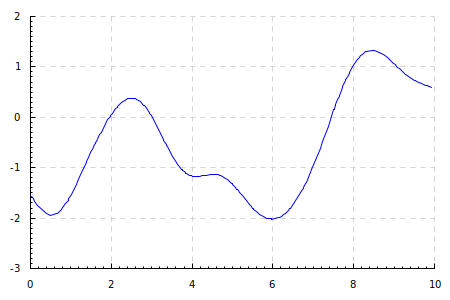

In [11]:
(n,x,y,z) <- simulate (model 25)
toRenderable . plot $ line "" [list x `zip` list y]

In [12]:
gpc :: R -> Z -> P (R,R,RVec,RVec,BVec)
gpc t n = do
  lsv <- normal 0 1
  lls2 <- normal (log 100) 2
  x <- uniforms (vector [ 0 | i <- 1...n ]) (vector [ t | i <- 1...n ])
  (y,z) <- gpClassifier (kernelSE' lsv lls2 1e-6) n x
  return (lsv,lls2,x,y,z)

In [13]:
samples <- hmcStan 1000 [(lsv,lls2,y') | (lsv,lls2,x',y',z') <- gpc 10 n, x' == x, z' == z]

--- Generating Stan code ---
data {
  
  
  vector[242] x_stan_0_2;
  
  int<lower=0,upper=1> x_stan_0_4[242];
}
parameters {
  real x_stan_0_0;
  real x_stan_0_1;
  
  vector[242] x_stan_0_3;
  
}
model {
  vector[242] v_0_0;
  
  
  vector[242] v_0_3;
  matrix[242,1] v_0_4;
  matrix[1,242] v_0_5;
  matrix[242,242] v_0_6;
  matrix[242,1] v_0_7;
  matrix[1,242] v_0_8;
  matrix[242,242] v_0_9;
  matrix[242,242] v_0_10;
  matrix[242,242] v_0_11;
  
  real v_0_13;
  real v_0_14;
  matrix[242,242] v_0_15;
  matrix[242,242] v_0_16;
  matrix[242,242] v_0_17;
  vector[242] v_0_18;
  matrix[242,242] v_0_19;
  matrix[242,242] v_0_20;
  matrix[242,242] v_0_21;
  
  vector[242] v_0_23;
  vector[242] v_0_24;
  
  for (i_1_1 in 1:242) {
  
    v_0_0[i_1_1] = 0;
  }
  
  
  v_0_3 = x_stan_0_2 .* x_stan_0_2;
  v_0_4 = to_matrix(to_vector(v_0_3));
  v_0_5 = to_matrix(to_row_vector(v_0_3));
  v_0_6 = rep_matrix(to_vector(v_0_4), 242) + rep_matrix(to_row_vector(v_0_5), 242);
  v_0_7 = to_matrix(to_vecto

In [14]:
let lo = floor   . minimum $ list y
    hi = ceiling . maximum $ list y

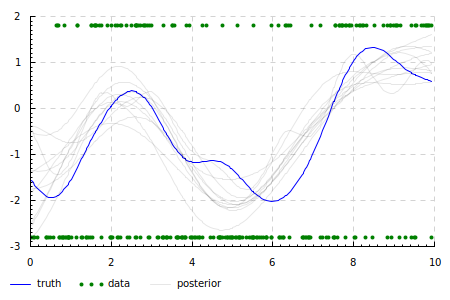

In [15]:
let ys = [y | (_,_,y) <- samples]
toRenderable $ do
  plot $ line "truth" [list x `zip` list y]
  plot $ points "data" $ list x `zip` [if b then real hi - 0.2 else real lo + 0.2 | b <- list z]
  setColors [black `withOpacity` 0.1]
  plot $ line "posterior" [list x `zip` list y' | (i,y') <- [0..] `zip` ys, i `mod` 100 == 0]